In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
import keras
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
(keras.__version__, tf.__version__)

Using TensorFlow backend.


('2.2.2', '1.10.0')

In [3]:
exch = 'BTRX'
pair = 'BTC/USDT'

df = pd.read_csv(f"{exch}_{pair.replace('/', '-')}_ohlcv.csv")
df.head()

,timestamp,open,high,low,close,volume
0,2016-12-31 05:02:00,948.000,948.000,942.899,942.899,0.083403
1,2016-12-31 05:03:00,942.899,942.899,942.899,942.899,0.000000
2,2016-12-31 05:04:00,942.899,942.899,942.899,942.899,0.000000
3,2016-12-31 05:05:00,942.899,942.899,942.899,942.899,0.000000
4,2016-12-31 05:06:00,942.899,942.899,942.899,942.899,0.000000


In [4]:
df.dtypes

timestamp     object
open         float64
high         float64
low          float64
close        float64
volume       float64
dtype: object

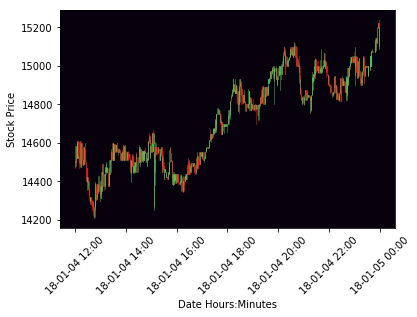

In [5]:
# Plot the stock prices for the last day
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

plot_last_n_minutes = 60 * 12  # 1/2 day
cs_frame = df.iloc[-1 * plot_last_n_minutes:].copy()  # Create the candlestick frame

#if necessary convert to datetime
cs_frame.timestamp = pd.to_datetime(cs_frame.timestamp)

cs_frame = cs_frame[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
cs_frame["timestamp"] = cs_frame["timestamp"].apply(mdates.date2num)

f1 = plt.subplot2grid((6, 1), (0, 0), rowspan=6, colspan=1, facecolor='#07000d')
candlestick_ohlc(f1, cs_frame.values, width=.0001, colorup='#53c156', colordown='#ff1717', alpha=.75)
f1.xaxis_date()
f1.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))

plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.xlabel('Date Hours:Minutes')
plt.show()

# Cleanup memory
%reset_selective -f "^cs_frame$"

In [6]:
# Add a minute moving average over period
def add_moving_avg(df, period=30):
    #df[f"{period}_ma"] = pd.rolling_mean(df['close'], period)
    df[f"{period}_ma"] = df.close.rolling(period).mean()

In [7]:
#add_moving_avg(df)
#df.tail()

In [8]:
from stock_gym.envs import stocks
import gym

env = gym.make('SinMarketEnv-v0')
#env.add_data(df)
(env.__class__.__name__, env.n_features, env.n_actions)

('SinMarketEnv', 1, 3)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, GRU, Dropout
from keras.optimizers import Adam

In [10]:
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [11]:
np.random.seed(123)
env.seed(123)
(env.n_actions, env.observation_shape())

(3, (1, 64))

In [12]:
model = Sequential()

model.add(GRU(16,
                #input_shape=env.observation_space.shape,
                input_shape=env.observation_shape(),
                dropout=0.1,
                recurrent_dropout=0.5,
                #return_sequences=True,
               #stateful=False,
             ))
# model.add(GRU(128,
#                 dropout=0.1,
#                 recurrent_dropout=0.5,
#                 return_sequences=True,
#              ))
# model.add(GRU(128,
#                 dropout=0.1,
#                 recurrent_dropout=0.5,
#              ))
#model.add(Dense(64))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(env.n_actions, kernel_initializer='lecun_uniform', activation='linear'))
#model.add(Activation('linear')) #linear output so we can have range of real-valued outputs
#model.add(Dense(env.n_actions, activation='linear'))

# model.add(Flatten(input_shape=env.observation_space.shape))
# model.add(Dense(16))
# model.add(Activation('relu'))
# model.add(Dense(16))
# model.add(Activation('relu'))
# model.add(Dense(16))
# model.add(Activation('relu'))
# model.add(Dense(env.n_actions, activation='linear'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 16)                3888      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 3,939
Trainable params: 3,939
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
memory = SequentialMemory(limit=env.total_space_size, window_length=env.n_features)
policy = BoltzmannQPolicy()

In [14]:
agent = DQNAgent(model=model, nb_actions=env.n_actions, memory=memory, nb_steps_warmup=100,
               enable_dueling_network=True, dueling_type='avg', target_model_update=1e-2, policy=policy)


In [15]:
#agent.compile(Adam(lr=1e-3), metrics=['mae'])
agent.compile(
    #loss='mse',
    optimizer=Adam(lr=1e-3),
    metrics=['mae'],
)

In [16]:
history = agent.fit(env, nb_steps=5000, visualize=False, verbose=1)

Training for 5000 steps ...
Interval 1 (0 steps performed)
 4998/10000 [=============>................] - ETA: 2:32 - reward: -99.0204done, took 152.909 seconds


In [17]:
# After training is done, we save the final weights.
agent.save_weights('duel_dqn_{}_weights.h5f'.format('stock_bot'), overwrite=True)

In [18]:
agent.test(env, nb_episodes=5, visualize=False)

Testing for 5 episodes ...
Episode 1: reward: -0.001, steps: 1
Episode 2: reward: -0.001, steps: 1
Episode 3: reward: -0.001, steps: 1
Episode 4: reward: -0.001, steps: 1
Episode 5: reward: -0.001, steps: 1
